# Introduction to Physics-Informed Neural Networks
#### The static, linear Euler-Bernoulli beam

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Content creators: Jasper O. Schommartz

Summer term 2024

---

#### In this notebook, you will...

* calibrate a PINN for the linear Euler-Bernoulli cantilever beam
* learn to explain the fundamental structure of PINNs.
* learn how PINNs can be implemented in Tensorflow.
* learn what distinguished PINNs from typical supervised learning methods.
* experience the influence of weights on the training performance of PINNs.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()

## 1. Theory of the geometrically linear Euler-Bernoulli beam

For this task we consider a cantilever beam with *fixed* support on the on the left an a transversal force acting on the free end of the beam.

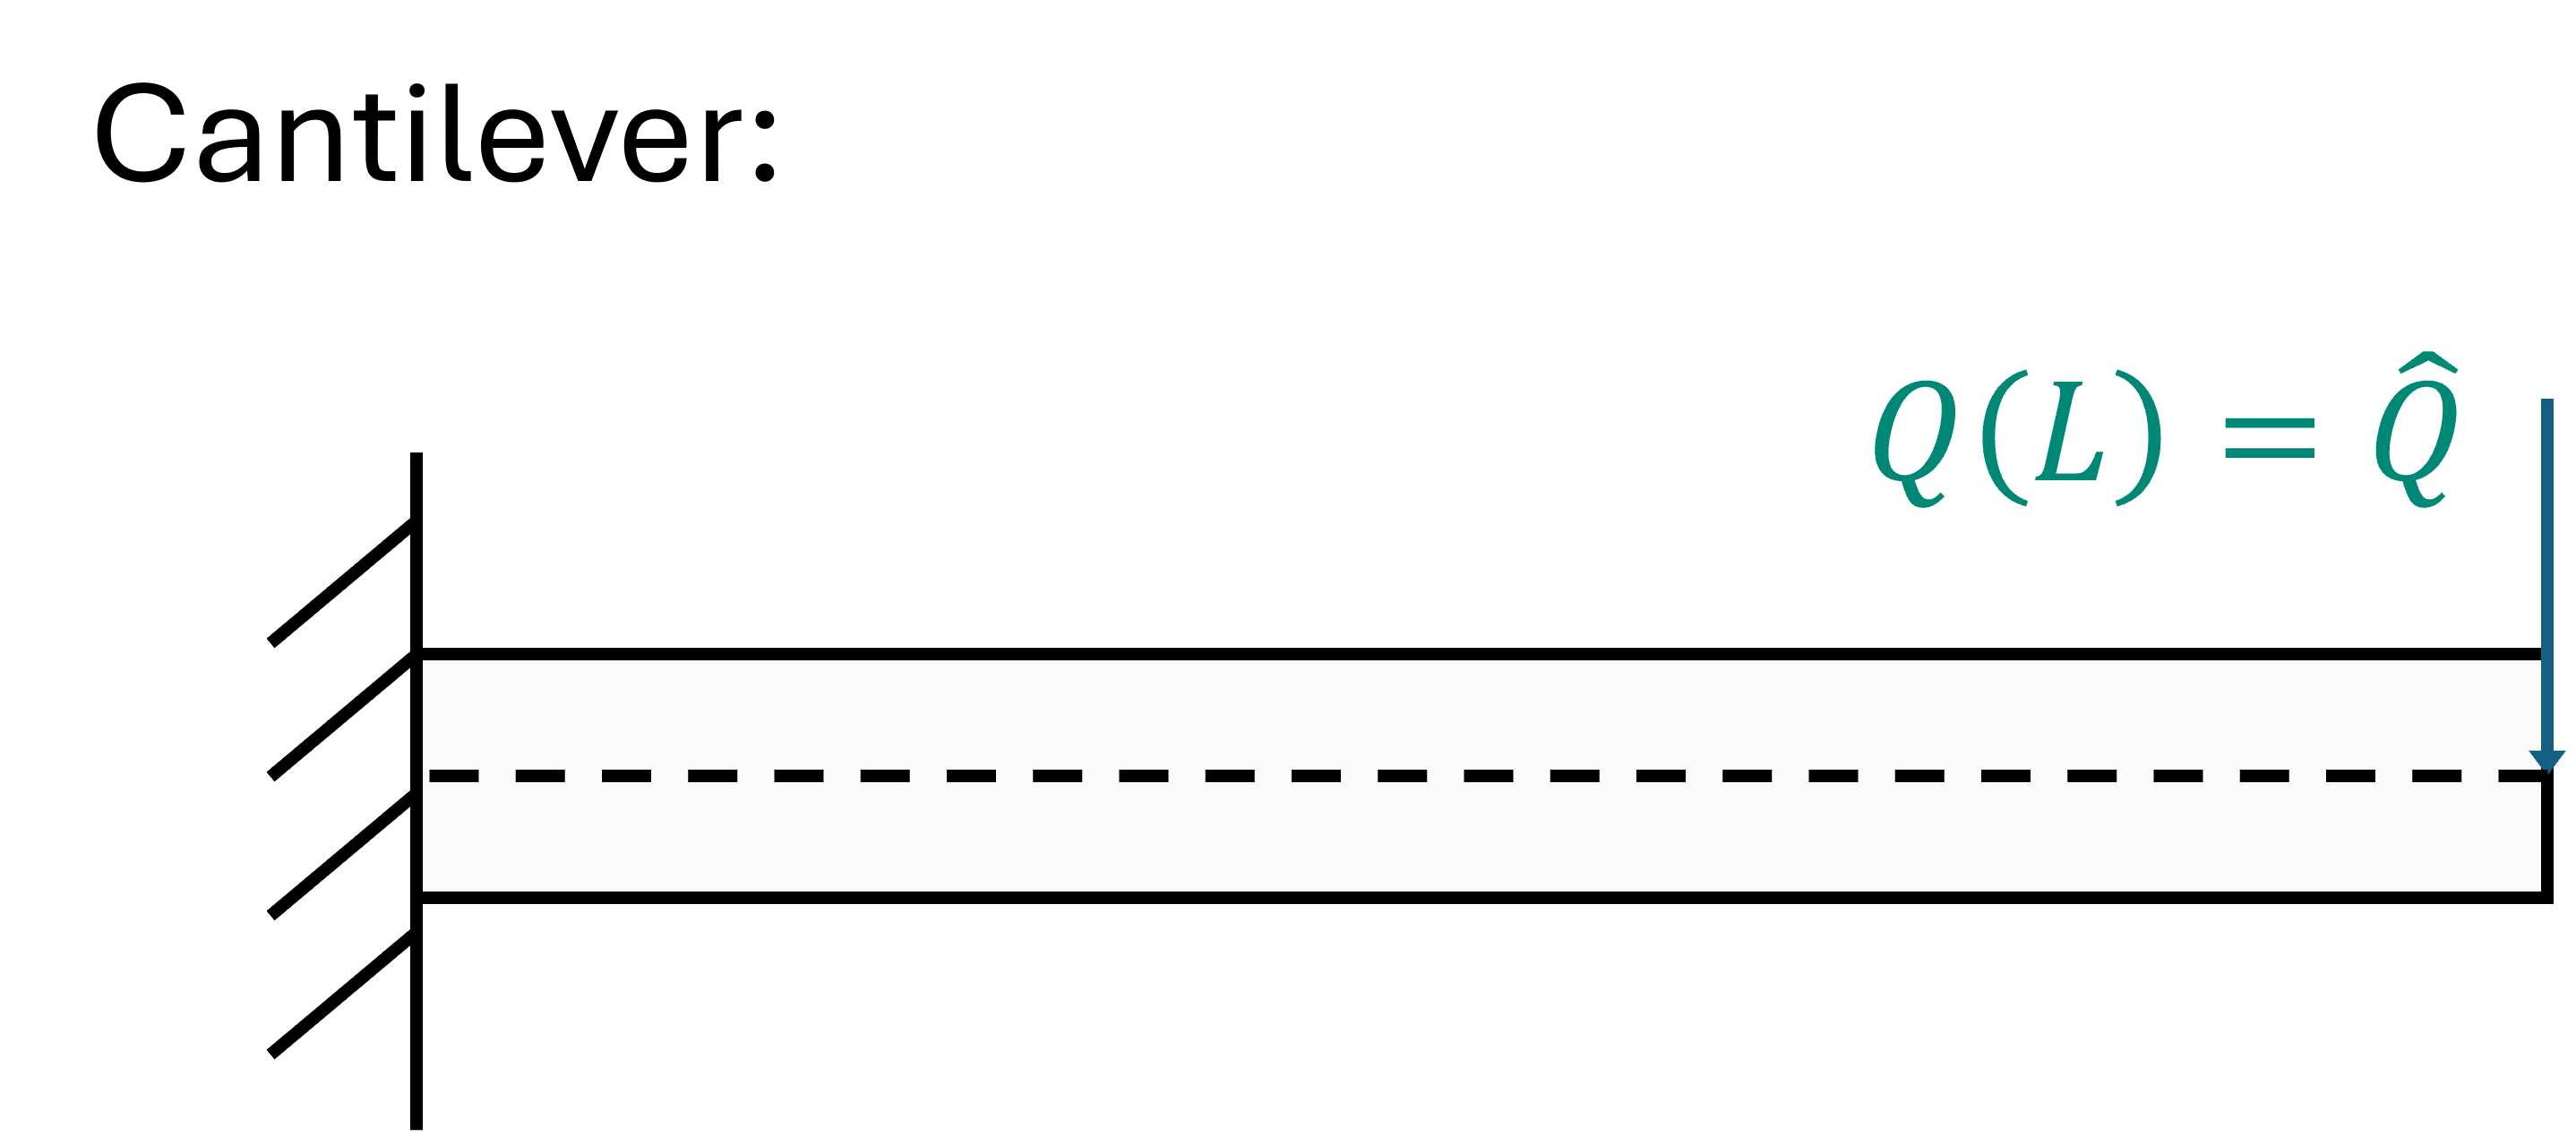

In the nonlinear case, the mechanical behavior of a cantilever beam is described by the coupled partial differential equations (PDEs)

$$
- N' = f(x) \quad\quad\quad\quad\quad (1)
$$
$$
- (Nw')' - M'' = q(x) \quad\quad(2),
$$

where $N = EA (u' + 0.5 (w')^2)$ and $M = - EI w ''$. The PDEs describe the balance of momentum in horizontal and vertical direction, respectively. If we assume the vertical displacements $w$ to be small, the PDEs can be decoupled, enabling separate computation of $u$ and $w$. In this task we are going to consider the vertical component of the decoupled system, which we refer to as the *linear Euler-Bernoulli beam*.

**Linear Euler-Bernoulli beam**

The mechanical behavior of the linear beam is decribed by a fourth order differential equation, which reads

$$
EI w^{(4)} = q(x).
$$

Here, $w$ is the vertical displacement and $q(x)$ denotes a transversal line load depending on the horizontal location $x$. The Young's modulus and the moment of inertia are denoted by $E$ and $I$, respectively. The Dirichlet boundary conditions of the cantilever beam are given by

$$
w(0) = w'(0) = 0
$$

and the Neumann boundary conditions read

$$
Q(L) = F,\quad M(L) = 0.
$$

### Non-dimensionalization:

As the Young's modulus $E$ and the moment of intertia $I$ can take large/small values in practice, it can be benefitial to non-dimensionalize the equations before training a physics-informed neural network (PINN). Therefore, we introduce the non-dimensional variables $\hat{x}$ and $\hat{w}$ as

$$ x = x_c \cdot \hat{x}\quad\text{and}\quad w = w_c \cdot \hat{w}, $$

and the non-dimensional derivatives $\hat{w}'$, $\hat{w}''$, $\hat{w}'''$, $\hat{w}^{(4)}$ as

$$ w' = \frac{w_c}{x_c} \hat{w}',\quad w'' = \frac{w_c}{x_c^2} \hat{w}'',\quad w''' = \frac{w_c}{x_c^3} \hat{w}''',\quad w^{(4)} = \frac{w_c}{x_c^4} \hat{w}^{(4)},$$

We choose $x_c = L$, which after insertion into the differential equation yields

$$
w_c = \frac{L^4}{E I}
$$

The *non-dimensional boundary value problem* (BVP) ultimatly reads

$$
\hat{w}^{(4)} =  \frac{x_c^4}{EI w_c} q(x_c \cdot \hat{x})
$$

with 

$$
\hat{w}(0) = 0,\quad \hat{w}'(0) = 0
$$

and

$$
E I \frac{w_c}{x_c^3} \hat{w}'''(1) = F,\quad \hat{w}''(1) = 0
$$

## 2. Task summary:

In this task we will use a PINN to model the linear Euler-Bernoulli cantilever beam and approximate the solution for the BVP presented above. Complete the following tasks:

1. Calibrate the provided PINN using only labeled data( `WPDE = 0`, `WDIR = 0`, `WNEU = 0` with `WDATA = 1`). What is the minimal required FFNN architecture to fit the data? How many epochs are required to fit the data? Is the solution of the PDE predicted correctly?  What about the derivatives? 
2. Use the architecture determined in Task 1 and calibrate the provided PINN without labeled data (`WPDE = 1`, `WDIR = 1`, `WNEU = 1` with  `WDATA = 0`). Is the solution of the PDE predicted predicted correctly?  What about the derivatives?
3. Calibrate the model using the PINN and labeled data (`WPDE = 1`, `WDIR = 1`, `WNEU = 1` with  `WDATA = 1`). What difference do you observed compared to Task 1? In which scenario could this be useful?
3. Calibrate the model using the PINN and labeled data (`WPDE = 1`, `WDIR = 1`, `WNEU = 0` with  `WDATA = 0`). Why does the model only predict nearly 0?
4. *Homework*: Implement and calibrate a PINN for different boundary conditions. Evaluate your results by implementing the analytical solution.


## 3. PINN model

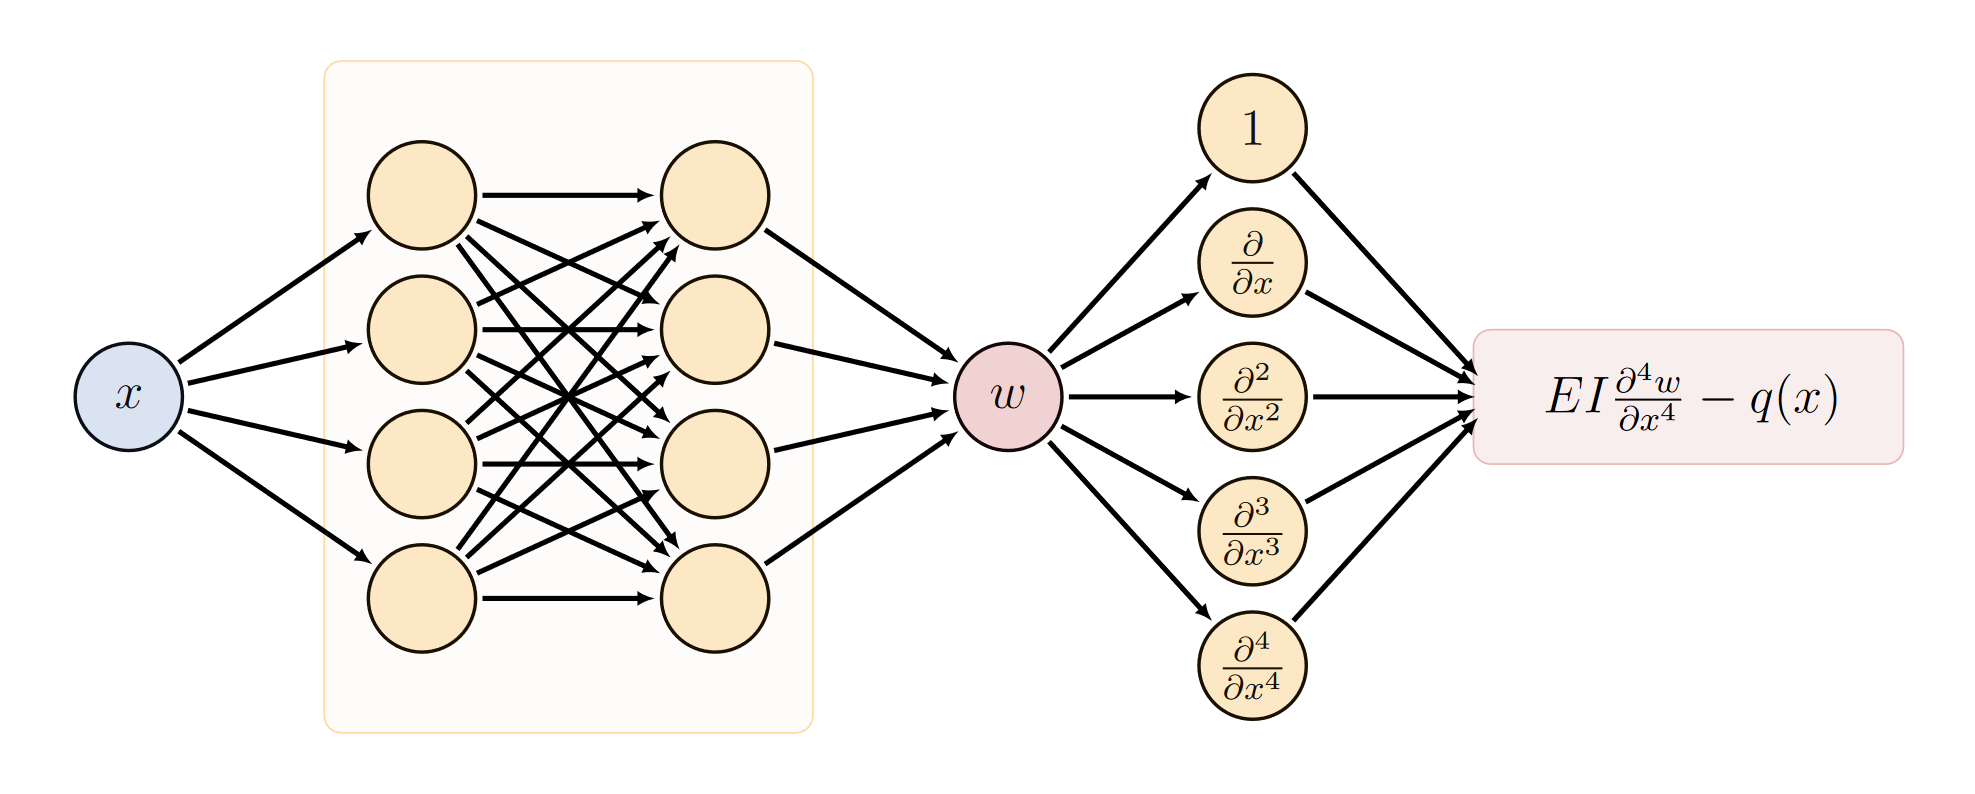

PINNs enforce the physicality of the solution in a weak manner via the loss $\mathcal{L}$. In its simplest form the loss consits of three parts and reads

$$
\mathcal{L} = \mathcal{L}_{data} + \mathcal{L}_{PDE} + \mathcal{L}_{BC}.
$$

Here, $\mathcal{L}_{data}$, denotes the error on a set of labeled data, $\mathcal{L}_{PDE}$ denotes the error of the underlying partial differential equations, and $\mathcal{L}_{BC}$ is the error of the boundary conditions. For this task we define the losses in terms of the non-dimensional variables $\hat{x}$ and $\hat{w}$ as

$$
\mathcal{L}_{DATA} = w_{DATA} \frac{1}{N_{DATA}} \sum_{i=1}^{N_{DATA}} \lvert\lvert \text{NN}(\hat{x}_i) - \hat{w}_i \rvert\rvert_{2}^2
$$
$$
\mathcal{L}_{PDE} = w_{PDE} \frac{1}{N_{PDE}} \sum_{i=1}^{N_{PDE}} \Big\lvert\Big\lvert \frac{\partial^4 \text{NN}(\hat{x}_i)}{\partial \hat{x}^4} - \frac{x_c^4}{EI w_c} q(x_c \cdot \hat{x}) \Big\rvert\Big\rvert_{2}^2
$$
$$
\begin{split}
\mathcal{L}_{BC} = \frac{1}{2} &w_{DIR} \frac{1}{2} \left[ \lvert\lvert \text{NN}(0) \rvert\rvert_{2}^2  + \Big\lvert\Big\lvert \frac{\partial \text{NN}(\hat{x}_i)}{\partial \hat{x}}\Big\rvert_{\hat{x}_i=0} \Big\rvert\Big\rvert_{2}^2 \right] + \\ 
\frac{1}{2} &w_{NEU} \frac{1}{2} \left[ \Big\lvert\Big\lvert \left(E I \frac{w_c}{x_c^3} \frac{\partial^3 \text{NN}(\hat{x}_i)}{\partial \hat{x}^3}\Big\rvert_{\hat{x}_i=1}\right)/F - 1 \Big\rvert\Big\rvert_{2}^2  + \Big\lvert\Big\lvert \frac{\partial^2 \text{NN}(\hat{x}_i)}{\partial \hat{x}^2}\Big\rvert_{\hat{x}_i=1} \Big\rvert\Big\rvert_{2}^2 \right].
\end{split}
$$

Each of the loss terms correspond to a weighted *mean squared error* with $w_{DATA}$, $w_{PDE}$, $w_{DIR}$ and $w_{NEU}$ denoting the weights of labeled data, the partial differential equation, the Dirichlet boundary conditions and the Neumann boundary conditions, respectively. In total, the the optimization problem that has to be solved consists of **six objectives**, which need to be satiesfied simultaneously.

**Implementaion**

The architecture and loss function presented above can be implemented as follows: First, we create a Tensorflow layer for the FFNN, i.e., `MLP`, and functions for the first to fourth derivatives with respect to $x$, i.e., `gradient()`, `second_gradient()`, `third_gradient()` and `fourth_gradient()`.

In [2]:
class MLP(layers.Layer):
    ''' A feed-forward neural network '''
    def __init__(self, units, activation):
        super().__init__()
        self.ls = []
        for (u, a) in zip(units, activation):
            self.ls += [layers.Dense(u, a)]

    def call(self, x):    
        for l in self.ls:
            x = l(x)
        return x

def gradient(f, x):
    ''' Computes the first derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u = f(x)
    du = tf.squeeze(g.batch_jacobian(u, x), 2)
    return u, du

def second_gradient(f, x):
    ''' Computes the second derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du = gradient(f, x)
    ddu = tf.squeeze(g.batch_jacobian(du, x), 2)
    return u, du, ddu

def third_gradient(f, x):
    ''' Computes the third derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du, ddu = second_gradient(f, x)
    dddu = tf.squeeze(g.batch_jacobian(ddu, x), 2)
    return u, du, ddu, dddu

def fourth_gradient(f, x):
    ''' Computes the fourth derivative of a function f '''
    with tf.GradientTape() as g:
        g.watch(x)
        u, du, ddu, dddu = third_gradient(f, x)
    ddddu = tf.squeeze(g.batch_jacobian(dddu, x), 2)
    return u, du, ddu, dddu, ddddu

Next, the `PINN` is implemented based on the nondimenional BVP for the linear Euler-Bernoulli cantilever beam. The `PINN` layer computes the four constituents of the loss function. That is, the residual of the differential equation, `res_pde`, the resuiduals of the Dirichlet and Neumann boundary conditions, `res_dir_bc` and `res_neu_bc`, and the residual of the labeled data `res_data`.

The properties `self.w_pde`, `self.w_dir`, `self.w_neu`, `self.w_data` are scaling factors that define the weighting of every term in the loss function. 

**Note** that the PINN receives dimensional data as inputs for `labeled_data` and `x`, which is nondimensionalized within the PINN layer before passing it to the FFNN and the loss terms.

In [3]:
class PINN(layers.Layer):
    ''' Physics-informed neural network for the non-dimensional, linear Euler-Bernoulli beam '''
    def __init__(self, w_pde, w_dir, w_neu, w_data, param, labeled_data=None, **kwargs):
        super().__init__()
        # Create a FFNN
        self.mlp = MLP(**kwargs)

        # Weights
        self.w_pde = tf.constant(w_pde, dtype=tf.float32)
        self.w_dir = tf.constant(w_dir, dtype=tf.float32)
        self.w_neu = tf.constant(w_neu, dtype=tf.float32)
        self.w_data = tf.constant(w_data, dtype=tf.float32)

        # Beam parameters
        self.EA = tf.constant(param[0] * param[1], dtype=tf.float32)
        self.EI = tf.constant(param[0] * param[2], dtype=tf.float32)

        # Nondimensional parameters
        self.x_c = tf.constant(param[3], dtype=tf.float32)
        self.w_c = self.x_c / self.EI

        # x-values of the Dirichlet BCs
        self.zero = tf.zeros([1,1])
        self.L = tf.ones([1,1]) * param[3]

        # Value of the inhomogeneous Neumann BC (dimensional)
        self.F = tf.constant(5., dtype=tf.float32)

        # Labeled data of the form [x, w]
        self.labeled_data_x = tf.constant(labeled_data[0], dtype=tf.float32) / self.x_c
        self.labeled_data_w = tf.constant(labeled_data[1], dtype=tf.float32) * self.w_c ** (-1)

    def call(self, x):
        ''' Main PINN function '''
        # nondimensionalize input
        x = x / self.x_c

        # evaluate MLP and outputs
        w, dw, ddw, dddw, ddddw = fourth_gradient(self.mlp, x)
        M = self._moment(ddw)
        Q = self._transversal_force(dddw)

        w0, dw0 = gradient(self.mlp, self.zero)
        _, _, ddwL, dddwL = third_gradient(self.mlp, self.L / self.x_c)

        # pde residual
        res_pde = tf.reduce_mean(
            tf.square(self._pde_residual(ddddw))
        )

        # Dirichlet boundary condition residuals
        res_dir_bc = (
            tf.square(w0)
            + tf.square(dw0)
        ) / 2

        # Neumann boundary condition residuals
        F = self._transversal_force(dddwL)
        res_neu_bc = (
            tf.square(F / self.F - 1)
            + tf.square(ddwL)
        ) / 2

        # labeled data residual
        res_data = self._labeled_data_residual()

        # assemble and add loss term
        total_loss = self.w_pde * res_pde + (self.w_dir * res_dir_bc + self.w_neu * res_neu_bc) / 2 + self.w_data * res_data
        self.add_loss(total_loss)

        return (
            w * self.w_c,
            dw * self.w_c / self.x_c,
            M, 
            Q,
            ddddw * self.w_c / tf.math.pow(self.x_c, 4)
        )
    
    def _pde_residual(self, ddddw):
        ''' Computes the residual of the differential equation'''
        return ddddw

    def _labeled_data_residual(self):
        ''' Computes the data loss using the mean squared error '''
        w = self.mlp(self.labeled_data_x)
        return tf.reduce_mean(tf.square(w - self.labeled_data_w))

    def _transversal_force(self, dddw):
        ''' Computes the transversal force '''
        return - self.EI * self.w_c / tf.math.pow(self.x_c, 3) * dddw
    
    def _moment(self, ddw):
        ''' Computes the bending moment '''
        return - self.EI * self.w_c / tf.square(self.x_c) * ddw

The PINN model can be generated by calling the `build()` function, which connects the input and output layer and compiles the model using our PINN loss function and the `'adam'` optimizer.

In [4]:
def build(*args, **kwargs):
    ''' Builds an evaluation model that returns the nodal displacements '''
    # define input shape
    x = tf.keras.Input(shape=(1,))
    # define which (custom) layers the model uses
    pinn = PINN(*args, **kwargs)
    w, dw, M, Q, ddddw = pinn(x)
    # connect input and output
    model = tf.keras.Model(inputs = [x], outputs = [w, dw, M, Q, ddddw])
    # define optimizer
    model.compile('adam')
    return model

## 4. Analytical data generation

The differential equation of the linear elastic Euler-Bernoulli beam can be solved analytically. With line load $q(x) = 0$ the solution reads

$$
EI w(x) = \frac{1}{2} F L x^2 - \frac{1}{6} F x^3,
$$

where $Q(L) = F$.

In [5]:
convert = lambda x: tf.expand_dims(tf.constant(x, dtype='float32'), axis=1)

def analytical_ebb(EI, F, L, x):
    ''' Data genereation with the analytical solution of 
     the linear Euler-Bernoulli beam '''
    # compute analytical solution
    w = (0.5 * F * L * x ** 2 - 1. / 6. * F * x ** 3) / EI
    dw = (F * L * x - 0.5 * F * x ** 2) / EI
    M = F * (x - L)
    Q = F * np.ones(x.shape)
    ddddw = np.zeros(x.shape)

    # convert to tensors
    x = convert(x)
    w = convert(w)
    dw = convert(dw)
    M = convert(M)
    Q = convert(Q)
    ddddw = convert(ddddw)

    return x, w, dw, M, Q, ddddw

After choosing a number of collocation points `n` and setting a value for the transversal force `F`, the data is generated using the the analytical model.

**Task:** Take a look at the plots of the analytical solutions. Do they align with your expectation?

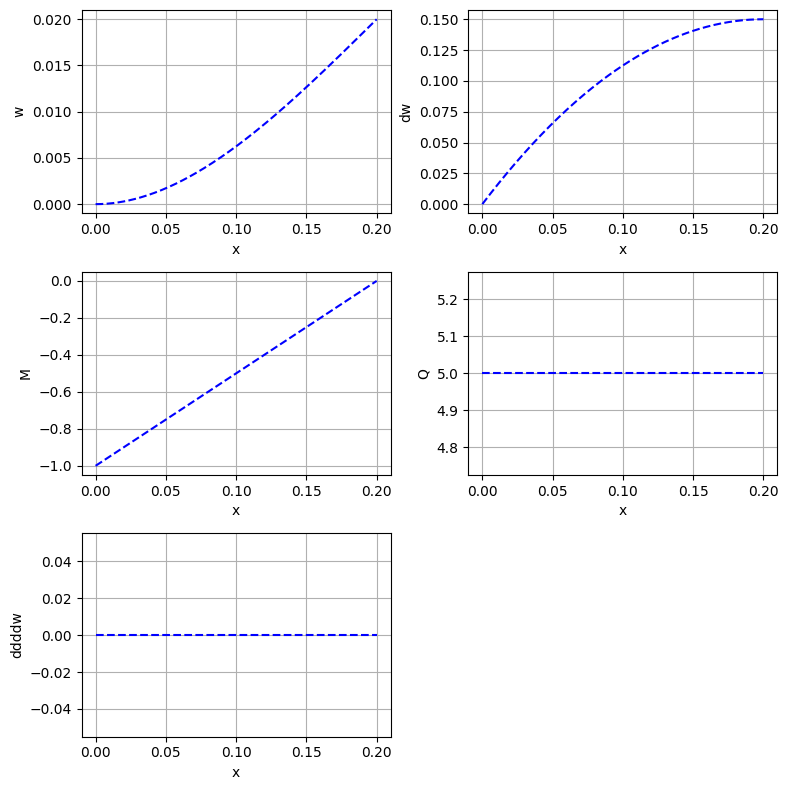

In [6]:
# Beam properties
L = 0.2            # Length [m]
W = 0.02           # Width [m]
H = 0.02           # Height [m]
E = 50e6           # Young's modulus [Pa]

# Cross-section parameters (assuming rectangular cross-section)
A = W * H
I = H ** 3 * W / 12
param = [E, A, I, L]

# Compute the analytical solution
n = 201 # number of collocation points
F = 5. # Transversal force at free end
x = np.linspace(0, L, n)

x, w, dw, M, Q, ddddw = analytical_ebb(E * I, F, L, x)

# Plot data
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
axs[0, 0].plot(x, w, 'b', linestyle='--')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('w')
axs[0, 0].grid()

axs[0, 1].plot(x, dw, 'b', linestyle='--')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('dw')
axs[0, 1].grid()

axs[1, 0].plot(x, M, 'b', linestyle='--')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('M')
axs[1, 0].grid()

axs[1, 1].plot(x, Q, 'b', linestyle='--')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Q')
axs[1, 1].grid()

axs[2, 0].plot(x, ddddw, 'b', linestyle='--')
axs[2, 0].set_xlabel('x')
axs[2, 0].set_ylabel('ddddw')
axs[2, 0].grid()

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

## 5. Build and calibrate PINN model

The `build()` function is called with the desired `units`, i.e., node number, and `activation` functions. Futhermore, the weights for PDE, Dirichlet, Neumann, and data losses can be set by adjusting the values of `WPDE`, `WDIR`, `WNEU`, and `WDATA`, respectively.

Note, that we can pass `labeled_data` to the model. In practice this can be useful if measured data shall be included in the training process.

**Task**: Adjust the values of `WPDE`, `WDIR`, `WNEU`, and `WDATA` and investigate their impact on the PINNs performance. What can you learn about the convergence of PINNs?

In [7]:
# Loss weights
WPDE = 1.
WDIR = 1.
WNEU = 1.
WDATA = 0.

# Load model
model = build(WPDE, WDIR, WNEU, WDATA, param,
    labeled_data=[x, w],
    units=[8, 1],
    activation=['softplus', 'linear']
)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 pinn (PINN)                 ((None, 1),               25        
                              (None, 1),                         
                              (None, 1),                         
                              (None, 1),                         
                              (None, 1))                         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Next, the model is fitted to the training data after defining the number of training epochs, i.e, `NEPOCHS`, and the learning rate for the ADAM optimizer. As opposed to the previous tasks, PINNs can perform **unsupervised** learining, meaning that no labeled output data has to be provided for training. Since Tensorflow still requires the definition of output values in the `fit()` function, we pass the dummy outputs `[x, x, x, x, x]`.

**Task**: Try to understand why the dummy outputs do not impact the training.

Epoch 1/5000
7/7 - 2s - loss: 0.6321 - 2s/epoch - 320ms/step
Epoch 2/5000
7/7 - 0s - loss: 0.5975 - 8ms/epoch - 1ms/step
Epoch 3/5000
7/7 - 0s - loss: 0.5652 - 7ms/epoch - 1000us/step
Epoch 4/5000
7/7 - 0s - loss: 0.5352 - 7ms/epoch - 1000us/step
Epoch 5/5000
7/7 - 0s - loss: 0.5075 - 8ms/epoch - 1ms/step
Epoch 6/5000
7/7 - 0s - loss: 0.4821 - 7ms/epoch - 1000us/step
Epoch 7/5000
7/7 - 0s - loss: 0.4588 - 7ms/epoch - 1000us/step
Epoch 8/5000
7/7 - 0s - loss: 0.4376 - 6ms/epoch - 857us/step
Epoch 9/5000
7/7 - 0s - loss: 0.4182 - 7ms/epoch - 1ms/step
Epoch 10/5000
7/7 - 0s - loss: 0.4006 - 7ms/epoch - 1000us/step
Epoch 11/5000
7/7 - 0s - loss: 0.3845 - 8ms/epoch - 1ms/step
Epoch 12/5000
7/7 - 0s - loss: 0.3698 - 7ms/epoch - 1000us/step
Epoch 13/5000
7/7 - 0s - loss: 0.3564 - 7ms/epoch - 1ms/step
Epoch 14/5000
7/7 - 0s - loss: 0.3441 - 7ms/epoch - 1000us/step
Epoch 15/5000
7/7 - 0s - loss: 0.3329 - 6ms/epoch - 857us/step
Epoch 16/5000
7/7 - 0s - loss: 0.3226 - 6ms/epoch - 857us/step
Epoch

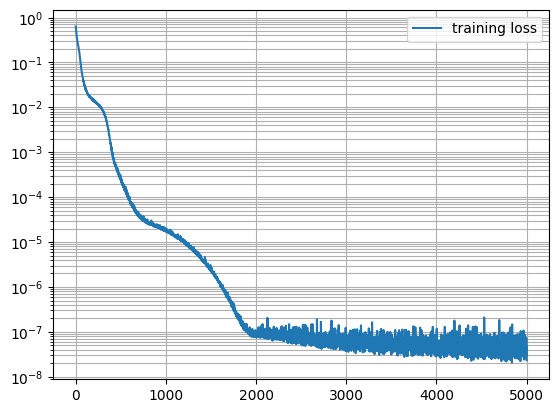

In [8]:
# Create collocation points
NCAL = 200 # number of collocation points
x_cal = tf.expand_dims(tf.convert_to_tensor(np.linspace(0, L, NCAL), dtype=tf.float32), 1)

# Calibrate model
NEPOCHS = 5000
model.optimizer.learning_rate.assign(0.001)
h = model.fit([x_cal], [x_cal, x_cal, x_cal, x_cal, x_cal],
              epochs=NEPOCHS,
              verbose=2,
              batch_size=32)

plt.semilogy(np.linspace(1, NEPOCHS, NEPOCHS), h.history['loss'], label='training loss')
plt.grid(which='both')
plt.legend()
plt.show()

In [9]:
# Save weights
model.save_weights('weights_lebb_01.h5')

In [10]:
# Load weights to skip the training
model.load_weights('weights_lebb_01.h5')

## 6. Evaluation

To evaluate the performance of the PINN we compare its predictions to the analytical solution.

**Task**: Take a close look a the model predictions. Do they correspond to the analytical solution? What about the derivatives?

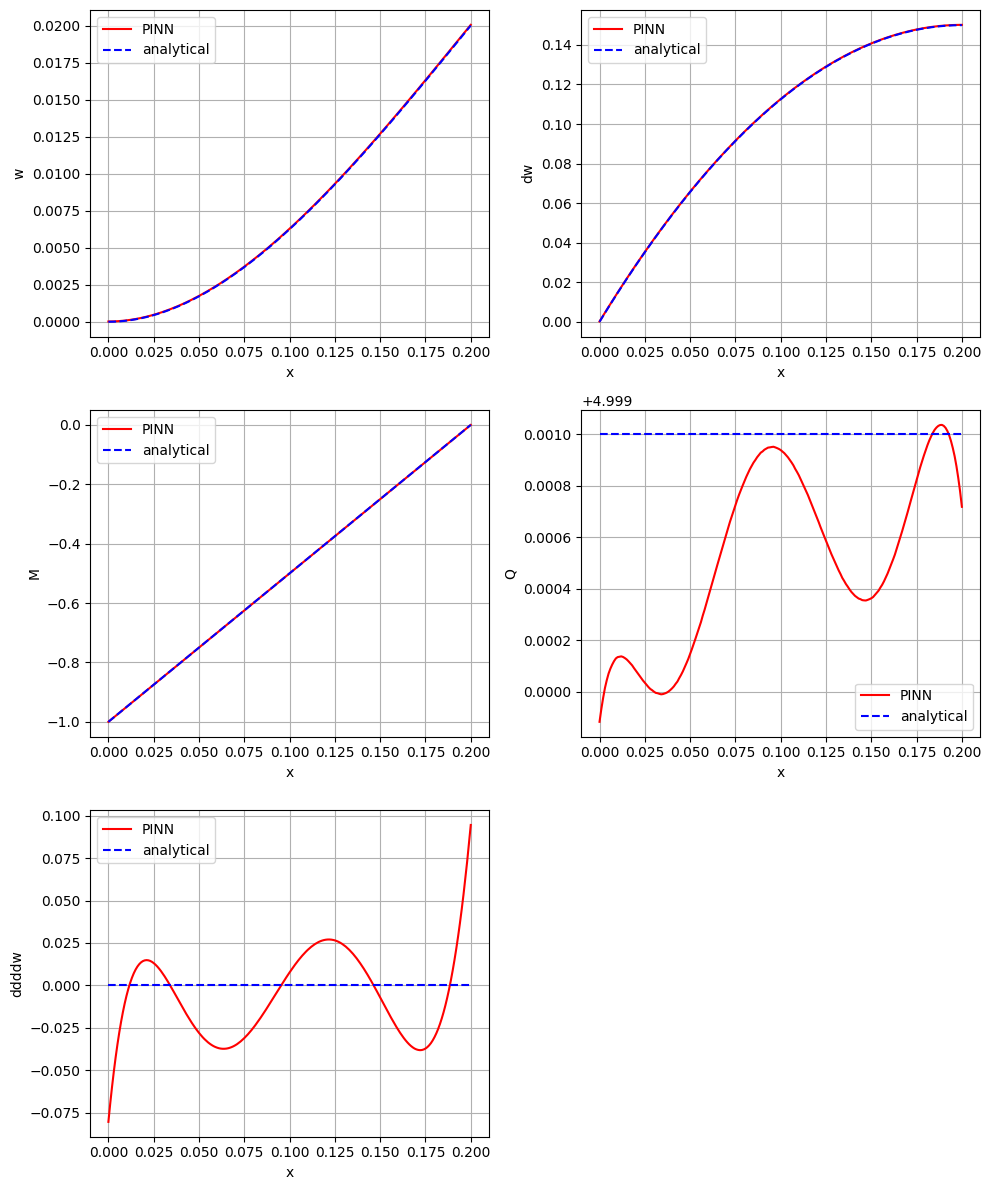

In [11]:
# Get model predictions
w_pinn, dw_pinn, M_pinn, Q_pinn, ddddw_pinn = model(x)

# Plot data and prediction
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axs[0, 0].plot(x, w_pinn, 'r', label='PINN')
axs[0, 0].plot(x, w, 'b', linestyle='--', label='analytical')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('w')
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(x, dw_pinn, 'r', label='PINN')
axs[0, 1].plot(x, dw, 'b', linestyle='--', label='analytical')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('dw')
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(x, M_pinn, 'r', label='PINN')
axs[1, 0].plot(x, M, 'b', linestyle='--', label='analytical')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('M')
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(x, Q_pinn, 'r', label='PINN')
axs[1, 1].plot(x, Q, 'b', linestyle='--', label='analytical')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Q')
axs[1, 1].grid()
axs[1, 1].legend()

axs[2, 0].plot(x, ddddw_pinn, 'r', label='PINN')
axs[2, 0].plot(x, ddddw, 'b', linestyle='--', label='analytical')
axs[2, 0].set_xlabel('x')
axs[2, 0].set_ylabel('ddddw')
axs[2, 0].grid()
axs[2, 0].legend()

axs[2, 1].axis("off")

plt.tight_layout()
plt.show()